# Загрузка собственного набора изображений в TensorFlow и Keras


In [74]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline 

## Загружаем данные

In [75]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
! kaggle datasets download -d moltean/fruits

fruits.zip: Skipping, found more recently modified local copy (use --force to force download)


In [77]:
! unzip fruits.zip

Archive:  fruits.zip
replace fruits-360-original-size/fruits-360-original-size/Meta/apple_6/info.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Создаем Tensorflow Dataset'ы 

In [78]:
batch_size=256
image_size=(100, 100)

**Набор данных для обучения**

In [79]:
train_dataset = image_dataset_from_directory('/content/fruits-360-original-size/fruits-360-original-size/Training',
                                             subset='training',
                                             seed=42,
                                             validation_split=0.1,
                                             batch_size=batch_size,
                                             image_size=image_size)

Found 6231 files belonging to 24 classes.
Using 5608 files for training.


**Проверочный набор данных**

In [80]:
validation_dataset = image_dataset_from_directory('/content/fruits-360-original-size/fruits-360-original-size/Validation',
                                             subset='validation',
                                             seed=42,
                                             validation_split=0.1,
                                             batch_size=batch_size,
                                             image_size=image_size)

Found 3114 files belonging to 24 classes.
Using 311 files for validation.


Названия классов в наборах данных.

In [81]:
class_names = train_dataset.class_names
class_names

['apple_6',
 'apple_braeburn_1',
 'apple_crimson_snow_1',
 'apple_golden_1',
 'apple_golden_2',
 'apple_golden_3',
 'apple_granny_smith_1',
 'apple_hit_1',
 'apple_pink_lady_1',
 'apple_red_1',
 'apple_red_2',
 'apple_red_3',
 'apple_red_delicios_1',
 'apple_red_yellow_1',
 'apple_rotten_1',
 'cabbage_white_1',
 'carrot_1',
 'cucumber_1',
 'cucumber_3',
 'eggplant_violet_1',
 'pear_1',
 'pear_3',
 'zucchini_1',
 'zucchini_dark_1']

**Примеры изображений**

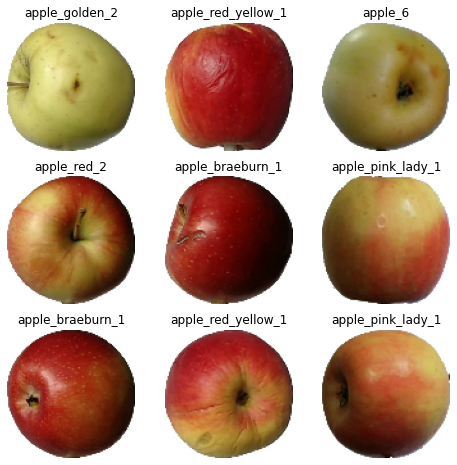

In [82]:
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**Набор данных для тестирования**

In [83]:
test_dataset = image_dataset_from_directory('/content/fruits-360-original-size/fruits-360-original-size/Test',
                                             batch_size=batch_size,
                                             image_size=image_size)

Found 3110 files belonging to 24 classes.


In [84]:
test_dataset.class_names

['apple_6',
 'apple_braeburn_1',
 'apple_crimson_snow_1',
 'apple_golden_1',
 'apple_golden_2',
 'apple_golden_3',
 'apple_granny_smith_1',
 'apple_hit_1',
 'apple_pink_lady_1',
 'apple_red_1',
 'apple_red_2',
 'apple_red_3',
 'apple_red_delicios_1',
 'apple_red_yellow_1',
 'apple_rotten_1',
 'cabbage_white_1',
 'carrot_1',
 'cucumber_1',
 'cucumber_3',
 'eggplant_violet_1',
 'pear_1',
 'pear_3',
 'zucchini_1',
 'zucchini_dark_1']

## Настраиваем производительность TensorFlow DataSet'ов

In [85]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Создаем нейронную сеть

In [86]:
# Создаем последовательную модель
model = Sequential()
# Сверточный слой
model.add(Conv2D(16, (5, 5), padding='same', 
                 input_shape=(100, 100, 3), activation='relu'))
# Слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Сверточный слой
model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
# Слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Сверточный слой
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
# Слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Сверточный слой
model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
# Слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Полносвязная часть нейронной сети для классификации
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
# Выходной слой, 131 нейрон по количеству классов
model.add(Dense(131, activation='softmax'))

**Компилируем модель**

In [87]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

## Обучаем нейронную сеть

In [88]:
history = model.fit(train_dataset, 
                    validation_data=validation_dataset,
                    epochs=4,
                    verbose=4)

Epoch 1/4
Epoch 2/4
Epoch 3/4
Epoch 4/4


## Оцениваем качетсво обучения сети

In [89]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(test_dataset, verbose=1)

13/13 [==============================] - 5s 147ms/step - loss: 0.0140 - accuracy: 0.9977


In [90]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 99.7749


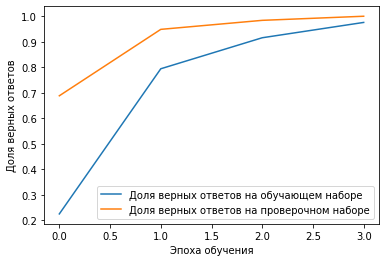

In [91]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

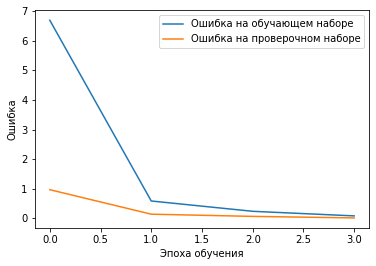

In [92]:
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()